# Group project 1b - Schelling's Segregation Model

While Conway's Game of Life is an interesting example of complex dynamics emerging from simple rules, it has no specific physical relevance.  However, other cellular automata can be used to model systems that occur in the real world, or at the very least their qualitative dynamics.  One such model is [Schelling's model of segregation](https://www.tandfonline.com/doi/abs/10.1080/0022250X.1971.9989794), which was developed by economist Thomas Schelling in 1971.  By this period in American history, housing discrimination had been nominally outlawed, and schools had (again, nominally) integrated.  However, Schelling still observed significant geographic segregation, particularly along racial lines in America.  In an effort to explain this phenomenon in as simple terms as possible, Schelling posited a model with the following rules for a game played on an NxN board (same as GoL).  
- The board contains pixels of one of three types, group 1 (which I like to encode as 1), group 2 (which I encode as -1), and empty.  The initial conditions can be varied, but we usually start with a random distribution of the groups (though not necessarily in equal proportions) 
- At each turn, we loop through all agents (I prefer to do this in random order).  Each agent counts its neighbors and if the fraction of neighbors (ignorning empty spaces) of the *opposite* type exceeds a certain threshold (Schelling thought that $1/3$ was a particularly interesting threshold), then the agent moves to a random vacant space elsewhere on the board, leaving its former location vacant.  Note that unlike Game of Life, the boards state is changing continuously rather than all at once following processing.
- Squares outside the grid are treated as vacant for the purpose of counting neighbors.  
  
That's pretty much it (an alternative description can be found on the [wikipedia page](https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation)).  **Your task is to code and visualize Schelling's model**.  This should be somewhat similar to (though not exactly the same as) GoL.  Explore some different 'satisfaction thresholds' and briefly describe the different qualitative behaviors that emerge for different choices.  

A quick note: one challenge is keeping track of the empty spaces that an agent can move to.  While it is possible to do some kind of random search of the board for an empty space, this is probably not a very efficient approach.  Take a moment to think about how you can keep a dynamic record of which spaces are open.  Harkening back to Data Structures, in my implementation I used a random bag for this.  If you opt to do a random traversal of the occupied spaces, you will need to do something similar.    


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML

# Schelling's segregation model
# https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation

In [4]:
# function to create the board
def create_board(N):
    board = np.random.choice([1,0,-1], N*N, p=[4.5/10,1/10,4.5/10]).reshape(N,N)
    return board

# function to update the board (keeping this in as it was my first attempt at the update function)
def update_board_old(board, N, threshold):
    # create a copy of the board
    new_board = board.copy()
    # we update the board 1 random cell at a time and return the new board
    # select a random cell
    i = np.random.randint(N)
    j = np.random.randint(N)
    # if the cell is empty, select another cell
    while board[i,j] == 0:
        i = np.random.randint(N)
        j = np.random.randint(N)
    # if the cell is occupied, check how many non-empty neighbors it has (edge cases don't count)
    non_empty_n = np.sum(board[max(0,i-1):min(N,i+2), max(0,j-1):min(N,j+2)] != 0) - 1 # -1 to remove the cell itself, max(0, i-1) to avoid negative indices when i = 0
    # get cell type
    cell_type = board[i,j]
    # get the number of like neighbors
    like_n = np.sum(board[max(0,i-1):min(N,i+2), max(0,j-1):min(N,j+2)] == cell_type) - 1
    # create f
    f = like_n / non_empty_n
    # print(f)
    # if f < threshold, move the cell to a random empty cell
    if f < threshold:
        # find all empty cells
        empty_cells = np.argwhere(board == 0) # argwhere returns the indices of the elements equal to 0 in this case (list of indices)
        # select a random empty cell
        empty_cell = empty_cells[np.random.randint(len(empty_cells))] # select a random empty cell
        # move the cell to the empty cell
        new_board[empty_cell[0], empty_cell[1]] = cell_type # move the cell
        new_board[i,j] = 0 # remove the cell from its original position
    # return the new board
    return new_board

def update_board_single(board, N, threshold):
    new_board = board.copy()
    moved = False 

    # get indices of non-empty cells
    non_empty_cells = np.argwhere(new_board != 0)
    # shuffle to randomize order
    np.random.shuffle(non_empty_cells) 

    # iterate through non-empty cells to find an unsatisfied cell
    for i, j in non_empty_cells:
        neighborhood = new_board[max(0, i-1):min(N, i+2), max(0, j-1):min(N, j+2)] # get the neighboring 8 cells using slicing (i.e. max(0, i-1) would return 0 if i-1 < 0)
        non_empty_n = np.count_nonzero(neighborhood)
        like_n = np.count_nonzero(neighborhood == new_board[i, j])

        # exclude the cell itself
        if new_board[i, j] != 0:
            non_empty_n -= 1
            like_n -= 1

        if non_empty_n > 0 and like_n / non_empty_n < threshold:
            # move the first unsatisfied cell found
            empty_cells = np.argwhere(new_board == 0)
            if empty_cells.size > 0:
                empty_cell = empty_cells[np.random.choice(empty_cells.shape[0])]
                new_board[empty_cell[0], empty_cell[1]] = new_board[i, j]
                new_board[i, j] = 0
                moved = True 
                break  # stop after moving one cell

    return new_board, moved

def update_board_multi(board, N, threshold):
    new_board = board.copy()
    moved = False
    # get indices of non-empty cells
    non_empty_cells = np.argwhere(new_board != 0)
    # shuffle to randomize order
    np.random.shuffle(non_empty_cells)

    # list to store unsatisfied cells
    unsatisfied_cells = []

    # identify unsatisfied cells
    for i, j in non_empty_cells:
        neighborhood = new_board[max(0, i-1):min(N, i+2), max(0, j-1):min(N, j+2)]
        non_empty_n = np.count_nonzero(neighborhood)
        like_n = np.count_nonzero(neighborhood == new_board[i, j])

        # exclude the cell itself
        if new_board[i, j] != 0:
            non_empty_n -= 1
            like_n -= 1

        if non_empty_n > 0:
            f = like_n / non_empty_n
            if f < threshold:
                unsatisfied_cells.append((i, j))

    # randomly move a subset of unsatisfied cells
    for i, j in unsatisfied_cells:
        empty_cells = np.argwhere(new_board == 0)
        if empty_cells.size > 0:
            empty_cell = empty_cells[np.random.choice(empty_cells.shape[0])]
            new_board[empty_cell[0], empty_cell[1]] = new_board[i, j]
            new_board[i, j] = 0

    if len(unsatisfied_cells) > 0:
        moved = True

    return new_board, moved

# function to plot the board
def plot_board(board, N, threshold):
    # create a figure
    fig = plt.figure()
    # create an axis
    ax = fig.add_subplot(111)
    # plot the board
    ax.imshow(board, cmap='bwr', vmin=-1, vmax=1)
    # set the title
    ax.set_title('Schelling\'s segregation model (threshold = {})'.format(threshold))
    # remove the axis
    ax.axis('off')
    # show the plot
    plt.show()

# Function for animating the list of states/frames
def animate_board(state_list, interval=40):
    fig,ax = plt.subplots()
    fig.set_size_inches(8,8)

    im = ax.imshow(state_list[0], cmap='bwr')
    im.set_cmap('bwr')

    def animate(frame_number):
        im.set_data(state_list[frame_number])
        return im
        
    animation = anim.FuncAnimation(fig, animate, frames=len(state_list), interval=interval)

    
    return HTML(animation.to_jshtml())

Number of iterations to reach equilibrium (SINGLE): 429


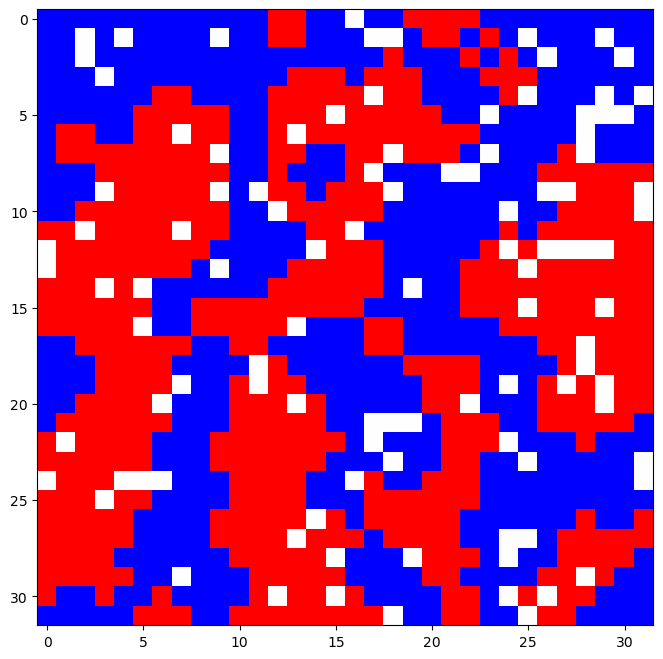

In [3]:
SIZE = 32
THRESH = 1/3
board = create_board(SIZE)
board_list = []
num_iterations = 0
while True:
    board_list.append(board)
    board, moved = update_board_single(board, SIZE, THRESH)
    num_iterations += 1
    if not moved:
        break


print('Number of iterations to reach equilibrium (SINGLE): {}'.format(num_iterations))
animate_board(board_list, interval=50)

In [ ]:
board = create_board(SIZE)
board_list_2 = []
num_iterations = 0
while True:
    board_list_2.append(board)
    board, moved = update_board_multi(board, SIZE, THRESH)
    num_iterations += 1
    if not moved:
        break

print('Number of iterations to reach equilibrium (MULTI): {}'.format(num_iterations))
animate_board(board_list_2, interval=50)

Threshold: 0.0 done
Threshold: 0.125 done
Threshold: 0.25 done
Threshold: 0.375 done
Threshold: 0.5 done
Threshold: 0.625 done
Threshold: 0.75 done
Threshold: 0.875 done


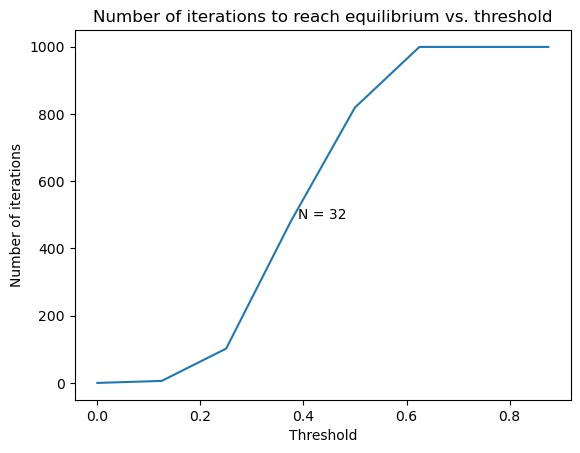

In [84]:
# function to run the simulation through different thresholds.  saving the number of iterations to reach equilibrium for each threshold
# then plotting the number of iterations vs. threshold
def run_simulation(N, threshold_list, num_iterations):
    num_iterations_list = []
    # loop through the thresholds
    for threshold in threshold_list:
        # create a board
        board = create_board(N)
        # loop through the iterations
        for i in range(num_iterations):
            # update the board
            board, moved = update_board_single(board, N, threshold)
            # if no cells moved, break
            if not moved:
                break
        # append the number of iterations to the list
        num_iterations_list.append(i)
        print('Threshold: {} done'.format(threshold))
    # plot the number of iterations vs. threshold
    plt.plot(threshold_list, num_iterations_list)
    plt.xlabel('Threshold')
    plt.ylabel('Number of iterations')
    plt.title('Number of iterations to reach equilibrium vs. threshold')
    # board size
    plt.text(0.5, 0.5, 'N = {}'.format(N), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.show()

thresh_list = [0/8, 1/8, 2/8, 3/8, 4/8, 5/8, 6/8, 7/8]
run_simulation(32, thresh_list, 1000)